In [ ]:
require(ggplot2)
require(mgcv)
require(lme4)

In [2]:
data = read.csv("data/aligned_ac_data.csv")[,-1]
names(data) = gsub("comp\\.([12])", "comp\\1", names(data))
data$filename = factor(data$filename)
data$collapse_func = factor(data$collapse_func)

In [3]:
head(data)

,ac_id,has_match,time_start,time_end,time_midpoint,speaker_gender,context_raw,position,syllable_structure,nasalized_perceived,⋯,offset_id,offset_s,phone,filename,comp1,comp2,next_offset_s,emit_id,has_midpoint,collapse_func
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>
1,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,439,13.17,n,劉櫂豪-127903,27.941244,29.770956,13.38,18,False,b
2,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,446,13.38,y,劉櫂豪-127903,-30.644875,-5.742225,13.50,19,False,b
3,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,450,13.50,ɕ,劉櫂豪-127903,57.967636,-22.112434,13.56,20,False,b
4,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,452,13.56,a,劉櫂豪-127903,-6.503804,41.149845,13.92,21,True,b
5,105,yes,21.15613,21.80866,21.73240,m,h_oN_f,f,cv,1,⋯,707,21.21,p,劉櫂豪-127903,-4.906386,-52.821700,21.27,36,False,b
6,105,yes,21.15613,21.80866,21.73240,m,h_oN_f,f,cv,1,⋯,709,21.27,u,劉櫂豪-127903,-66.930750,16.007505,21.36,37,False,b


In [4]:
# selected_phones = "[aeioənŋ]"

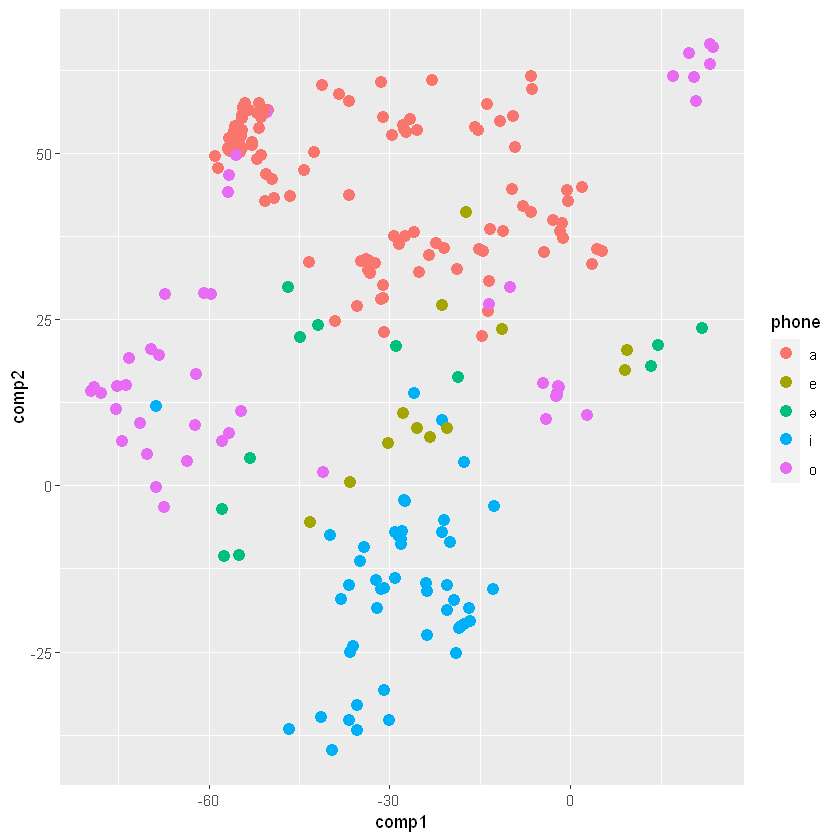

In [5]:
vdata = data[data$phone %in% unlist(strsplit("aeioə", split='')), ]
# vdata = vdata[vdata$comp1 < 0,]
ggplot(vdata, aes(x=comp1, y=comp2, color=phone)) + 
    geom_point(size=3)

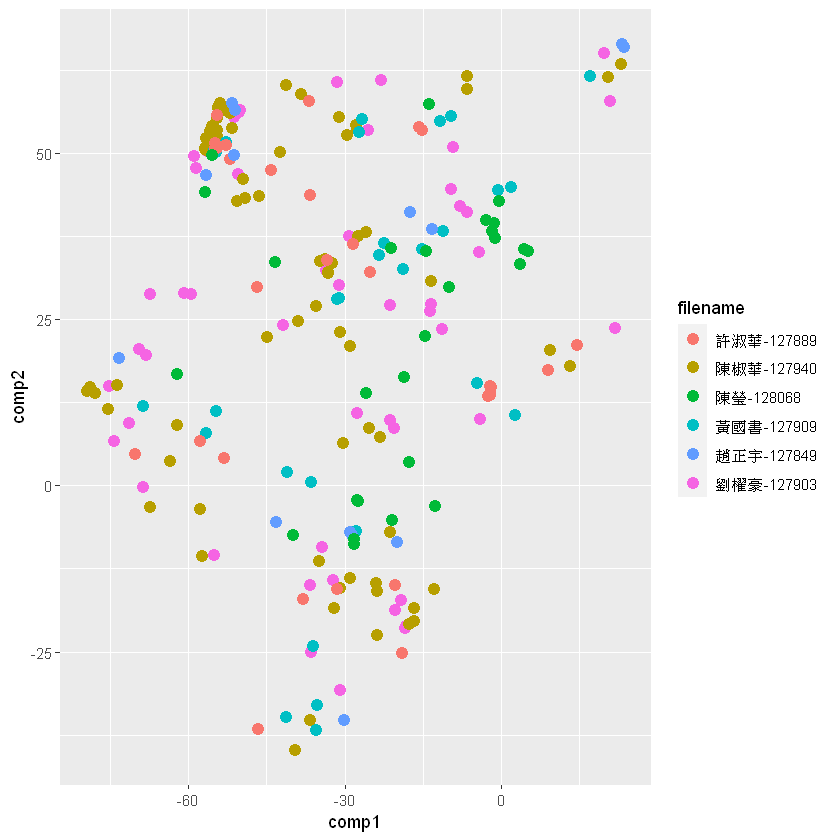

In [6]:
ggplot(vdata, aes(x=comp1, y=comp2, color=filename)) + 
    geom_point(size=3)

In [7]:
nrow(vdata)

[1] 250

In [8]:
length(unique(vdata$ac_id))

[1] 138

## Mixed model

In [9]:
m_f1 = lmer(freq_f1~comp1+comp2+(1|filename), data=vdata)
summary(m_f1)

Linear mixed model fit by REML ['lmerMod']
Formula: freq_f1 ~ comp1 + comp2 + (1 | filename)
   Data: vdata

REML criterion at convergence: 3210

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2666 -0.4591  0.0332  0.4534  3.2931 

Random effects:
 Groups   Name        Variance Std.Dev.
 filename (Intercept)  2303     47.99  
 Residual             22212    149.04  
Number of obs: 250, groups:  filename, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept) 729.59421   27.52587  26.506
comp1         0.01629    0.42692   0.038
comp2         0.29598    0.34575   0.856

Correlation of Fixed Effects:
      (Intr) comp1 
comp1  0.479       
comp2 -0.322  0.021

In [10]:
ranef(m_f1)

$filename
              (Intercept)
許淑華-127889    50.24665
陳椒華-127940    40.49140
陳瑩-128068     -30.58952
黃國書-127909    14.35532
趙正宇-127849   -55.83464
劉櫂豪-127903   -18.66921

with conditional variances for "filename" 

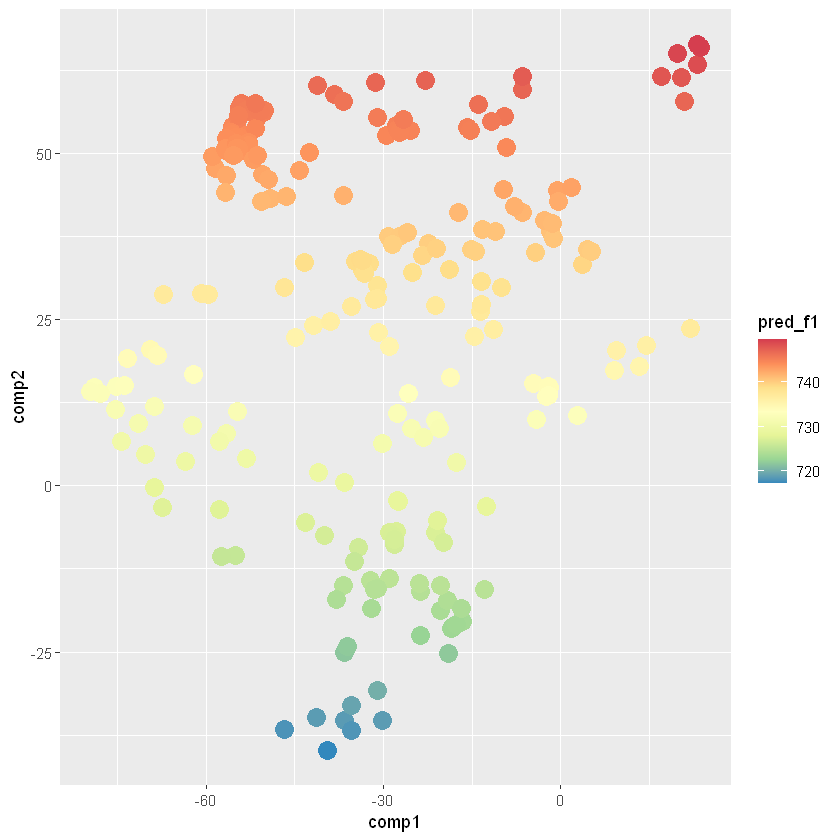

In [11]:
pred_f1 = predict(m_f1, re.form=NA)
ggplot(vdata, aes(x=comp1, y=comp2, color=pred_f1)) + 
    geom_point(size=5) + 
    scale_color_distiller(palette='Spectral')

In [12]:
m_f2 = lmer(freq_f2~comp1+comp2+(1|filename), data=vdata)
summary(m_f2)

Linear mixed model fit by REML ['lmerMod']
Formula: freq_f2 ~ comp1 + comp2 + (1 | filename)
   Data: vdata

REML criterion at convergence: 3486.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5147 -0.5027 -0.2614  0.1944  4.5856 

Random effects:
 Groups   Name        Variance Std.Dev.
 filename (Intercept)  1701     41.25  
 Residual             69211    263.08  
Number of obs: 250, groups:  filename, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept) 1206.0455    37.8025  31.904
comp1         -0.2187     0.7430  -0.294
comp2         -0.2773     0.6091  -0.455

Correlation of Fixed Effects:
      (Intr) comp1 
comp1  0.621       
comp2 -0.413  0.030

In [13]:
ranef(m_f2)

$filename
              (Intercept)
許淑華-127889    3.972207
陳椒華-127940    4.689566
陳瑩-128068    -13.038619
黃國書-127909   26.798651
趙正宇-127849   25.191445
劉櫂豪-127903  -47.613250

with conditional variances for "filename" 

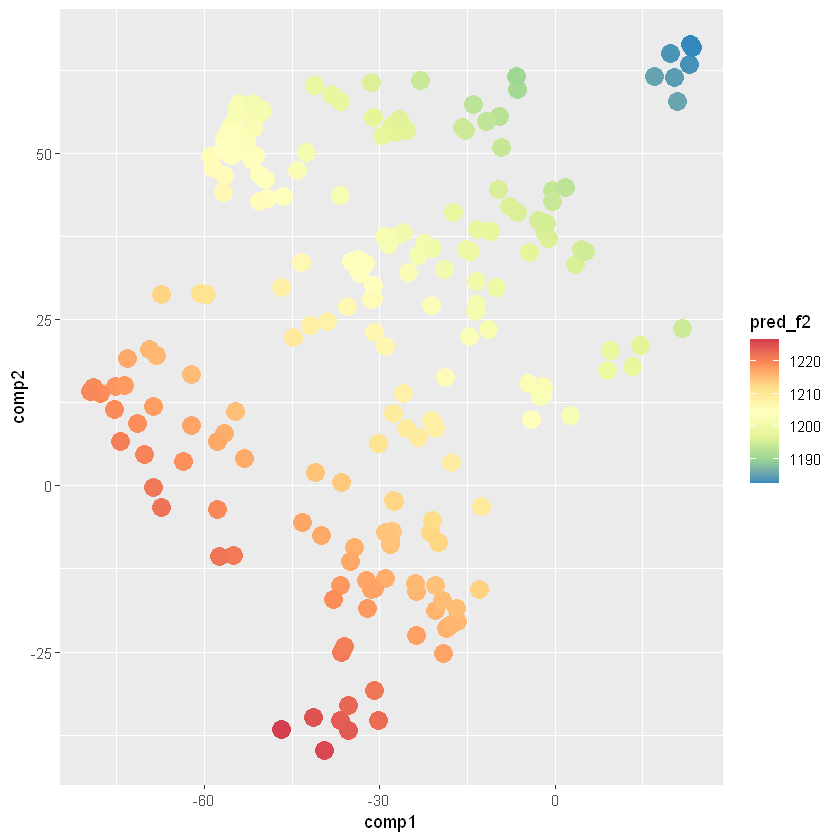

In [14]:
pred_f2 = predict(m_f2, re.form=NA)
ggplot(vdata, aes(x=comp1, y=comp2, color=pred_f2)) + 
    geom_point(size=5) + 
    scale_color_distiller(palette='Spectral')

## Get prediction error (bootstrap)

In [15]:
require(akima)

Loading required package: akima



In [16]:
predFun <- function(fit) {
    predict(fit, re.form=NA)
}


### F1 predictions

In [17]:
boot_mf1 <- bootMer(m_f1, nsim=200, FUN=predFun,seed=101)
predf1_mean = apply(boot_mf1$t, 2, mean)
predf1_se = apply(boot_mf1$t, 2, function(x) sd(x)/sqrt(length(x)))
interp_f1 = interp(vdata$comp1, vdata$comp2, predf1_se)
grid_f1se = expand.grid(interp_f1$x, interp_f1$y)
names(grid_f1se) = c("comp1", "comp2")
grid_f1se$f1_se = as.numeric(interp_f1$z)
grid_f1se = grid_f1se[!is.na(grid_f1se$f1_se),]

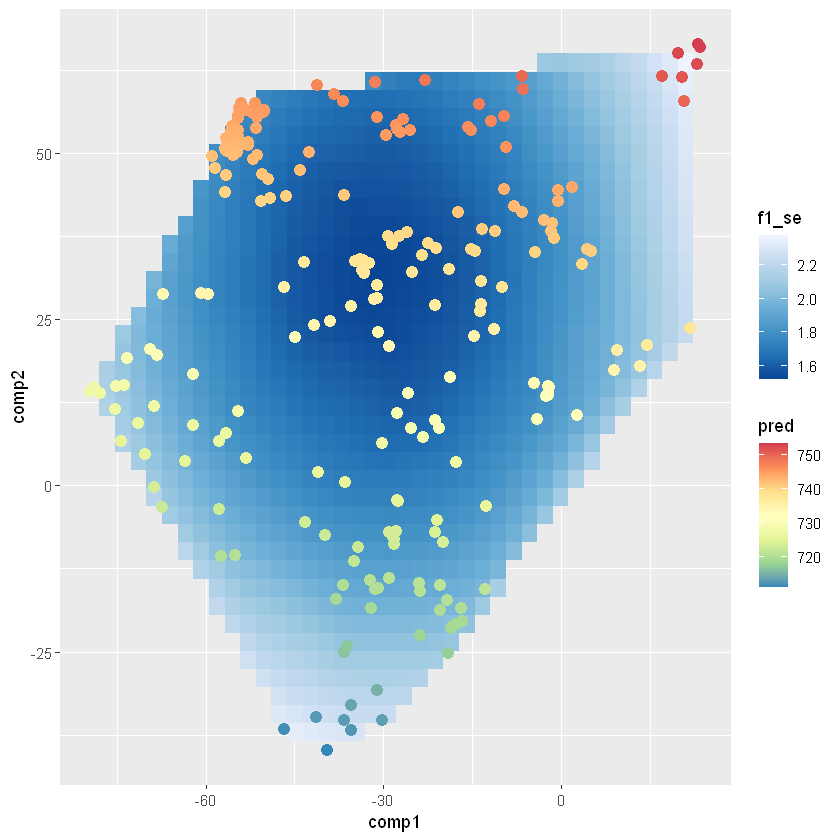

In [18]:
pred_f1 = data.frame(x=vdata$comp1, y=vdata$comp2, pred=predf1_mean)
ggplot() + 
    geom_raster(data=grid_f1se, aes(x=comp1, y=comp2, fill=f1_se)) + 
    geom_contour(color="white") + scale_fill_distiller(palette='Blues', direction=-1) + 
    geom_point(data=pred_f1, aes(x=x, y=y, color=pred), size=3) + 
    scale_color_distiller(palette='Spectral')

In [19]:
boot_mf2 <- bootMer(m_f2, nsim=200, FUN=predFun,seed=101)
predf2_mean = apply(boot_mf2$t, 2, mean)
predf2_se = apply(boot_mf2$t, 2, function(x) sd(x)/sqrt(length(x)))
interp_f2 = interp(vdata$comp1, vdata$comp2, predf2_se)
grid_f2se = expand.grid(interp_f2$x, interp_f2$y)
names(grid_f2se) = c("comp1", "comp2")
grid_f2se$f2_se = as.numeric(interp_f2$z)
grid_f2se = grid_f2se[!is.na(grid_f2se$f2_se),]

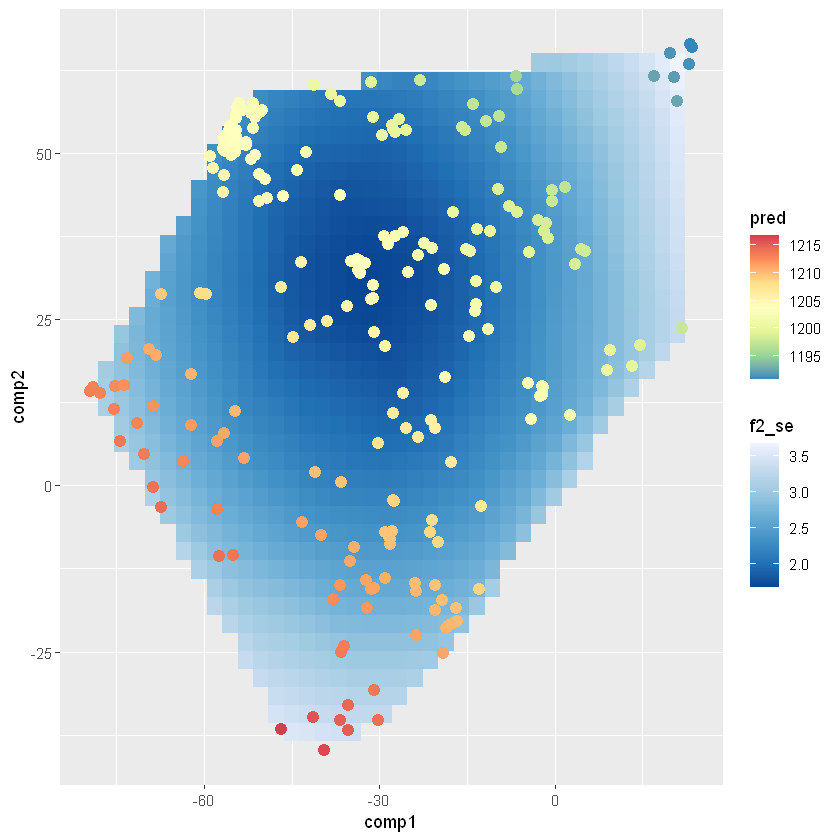

In [20]:
pred_f2 = data.frame(x=vdata$comp1, y=vdata$comp2, pred=predf2_mean)
ggplot() + 
    geom_raster(data=grid_f2se, aes(x=comp1, y=comp2, fill=f2_se)) + 
    geom_contour(color="white") + scale_fill_distiller(palette='Blues', direction=-1) + 
    geom_point(data=pred_f2, aes(x=x, y=y, color=pred), size=3) + 
    scale_color_distiller(palette='Spectral')